In [58]:
import pandas as pd
import numpy as np
import re

In [60]:
df = pd.read_parquet("train-00000-of-00001.parquet")
df = df.dropna(subset=['job_title', 'job_skill_set', 'job_description', 'category'])
print(df.head())

       job_id category                                 job_title  \
0  3902668440       HR              Sr Human Resource Generalist   
1  3905823748       HR                   Human Resources Manager   
2  3905854799       HR               Director of Human Resources   
3  3905834061       HR             Chief Human Resources Officer   
4  3906250451       HR  Human Resources Generalist (Hybrid Role)   

                                     job_description  \
0  SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXP...   
1  BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...   
2  OUR CLIENT IS A THRIVING ORGANIZATION OFFERING...   
3  JOB TITLE: CHIEF HUMAN RESOURCES OFFICER (CHRO...   
4  DESCRIPTION\n\n WHO WE ARE \n\nAVI-SPL IS A DI...   

                                       job_skill_set  
0  ['employee relations', 'talent acquisition', '...  
1  ['Talent Acquisition', 'Employee Performance M...  
2  ['Human Resources Management', 'Recruitment', ...  
3  ['talent management', 'organiza

In [62]:
job_counts = df['job_title'].value_counts()
threshold = 10
titles_to_keep = job_counts[job_counts >= threshold].index
df_filtered = df[df['job_title'].isin(titles_to_keep)].copy()
print(df_filtered.head())

        job_id category                   job_title  \
1   3905823748       HR     Human Resources Manager   
5   3901389277       HR     Human Resources Manager   
6   3902348043       HR  Human Resources Generalist   
8   3891070825       HR  Human Resources Generalist   
12  3894573937       HR  Human Resources Generalist   

                                      job_description  \
1   BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...   
5   JOB DESCRIPTION: · THE HR MANAGER WILL SUPPORT...   
6   DRIVE YOUR FUTURE WITH TURN 14 DISTRIBUTION! N...   
8   DIRECT-HIRE, $65,000 SALARY\nTHE IDEAL CANDIDA...   
12  COMPANY INFORMATION\n\nFOR MORE THAN 20 YEARS,...   

                                        job_skill_set  
1   ['Talent Acquisition', 'Employee Performance M...  
5   ['HR management', 'talent acquisition', 'labor...  
6   ['Microsoft Office', 'communication', 'attenti...  
8   ['recruitment', 'payroll administration', 'com...  
12  ['HRIS systems', 'Microsoft Office', 'data

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [66]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = " ".join(text.split())
    return text

df_filtered['job_title'] = df_filtered['job_title'].str.lower()
df_filtered['category'] = df_filtered['category'].str.lower()
df_filtered['clean_skills'] = df_filtered['job_skill_set'].apply(clean)
df_filtered['clean_desc'] = df_filtered['job_description'].apply(clean)

df_filtered['combined_features'] = df_filtered['clean_skills'] + " " + df_filtered['clean_desc']
df_final = df_filtered[['combined_features', 'job_title', 'category']].copy()
df_final.columns = ['skills', 'job_title', 'category']

tfidf = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1, 2))

print(df_final.head())

                                               skills  \
1   talent acquisition employee performance manage...   
5   hr management talent acquisition labor complia...   
6   microsoft office communication attention to de...   
8   recruitment payroll administration compliance ...   
12  hris systems microsoft office data analysis pr...   

                     job_title category  
1      human resources manager       hr  
5      human resources manager       hr  
6   human resources generalist       hr  
8   human resources generalist       hr  
12  human resources generalist       hr  


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

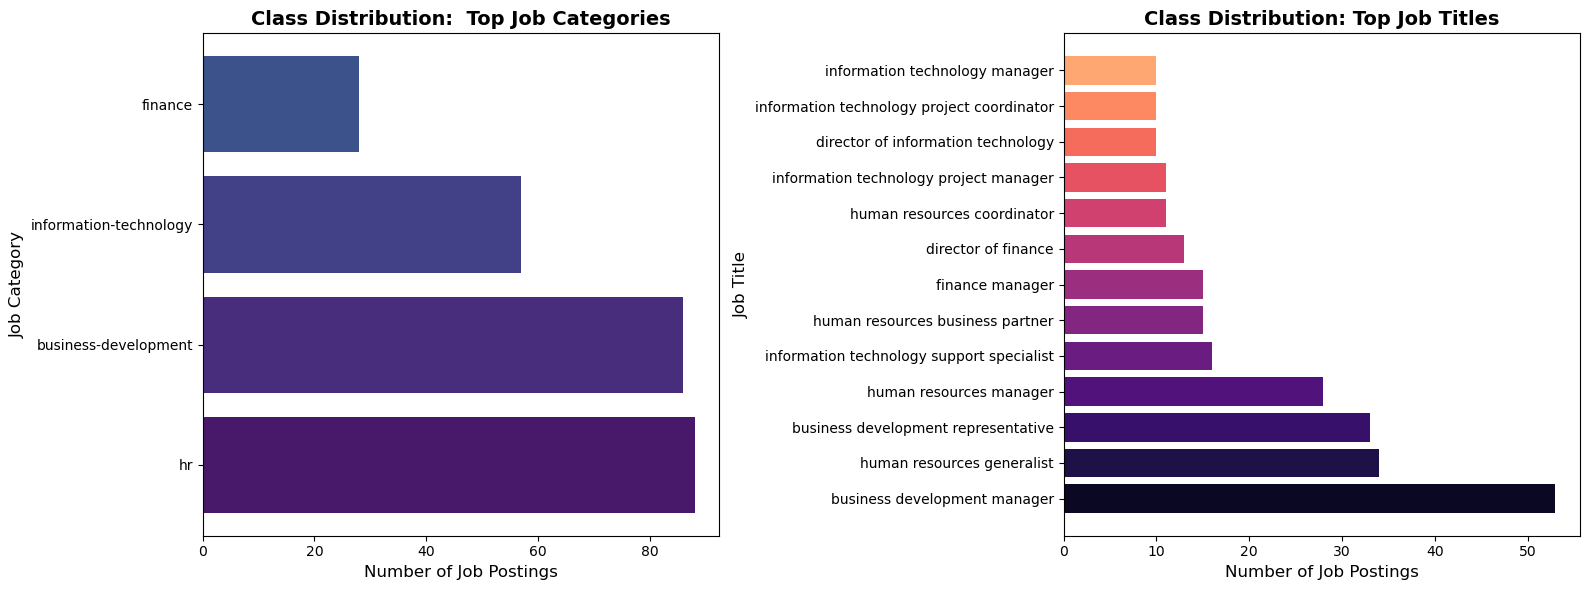


Total unique categories: 4
Total unique job titles: 13


In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

category_counts = df_filtered['category'].value_counts()
ax1 = axes[0]
bars1 = ax1.barh(category_counts.index[: 15], category_counts.values[:15], color=sns.color_palette("viridis", 15))
ax1.set_xlabel('Number of Job Postings', fontsize=12)
ax1.set_ylabel('Job Category', fontsize=12)
ax1.set_title('Class Distribution:  Top Job Categories', fontsize=14, fontweight='bold')

title_counts = df_filtered['job_title'].value_counts()
ax2 = axes[1]
bars2 = ax2.barh(title_counts.index[:15], title_counts.values[:15], color=sns.color_palette("magma", 15))
ax2.set_xlabel('Number of Job Postings', fontsize=12)
ax2.set_ylabel('Job Title', fontsize=12)
ax2.set_title('Class Distribution: Top Job Titles', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal unique categories: {df_filtered['category']. nunique()}")
print(f"Total unique job titles: {df_filtered['job_title'].nunique()}")

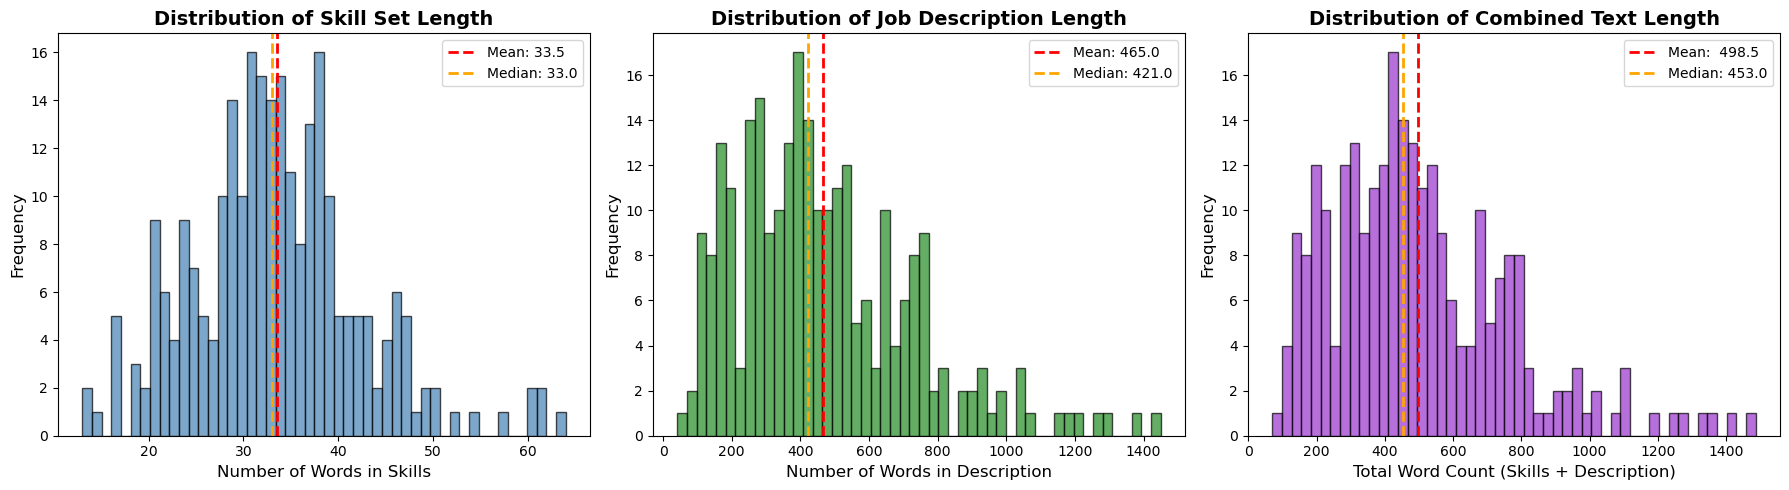

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_filtered['skill_length'] = df_filtered['clean_skills'].apply(lambda x: len(x.split()))
df_filtered['desc_length'] = df_filtered['clean_desc'].apply(lambda x: len(x.split()))
df_filtered['total_text_length'] = df_filtered['skill_length'] + df_filtered['desc_length']

axes[0].hist(df_filtered['skill_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_filtered['skill_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_filtered["skill_length"].mean():.1f}')
axes[0].axvline(df_filtered['skill_length'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_filtered["skill_length"].median():.1f}')
axes[0].set_xlabel('Number of Words in Skills', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Skill Set Length', fontsize=14, fontweight='bold')
axes[0].legend()

axes[1]. hist(df_filtered['desc_length'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(df_filtered['desc_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_filtered["desc_length"].mean():.1f}')
axes[1].axvline(df_filtered['desc_length'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_filtered["desc_length"].median():.1f}')
axes[1].set_xlabel('Number of Words in Description', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Job Description Length', fontsize=14, fontweight='bold')
axes[1].legend()

axes[2].hist(df_filtered['total_text_length'], bins=50, color='darkorchid', edgecolor='black', alpha=0.7)
axes[2].axvline(df_filtered['total_text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean:  {df_filtered["total_text_length"].mean():.1f}')
axes[2].axvline(df_filtered['total_text_length'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_filtered["total_text_length"].median():.1f}')
axes[2].set_xlabel('Total Word Count (Skills + Description)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Distribution of Combined Text Length', fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

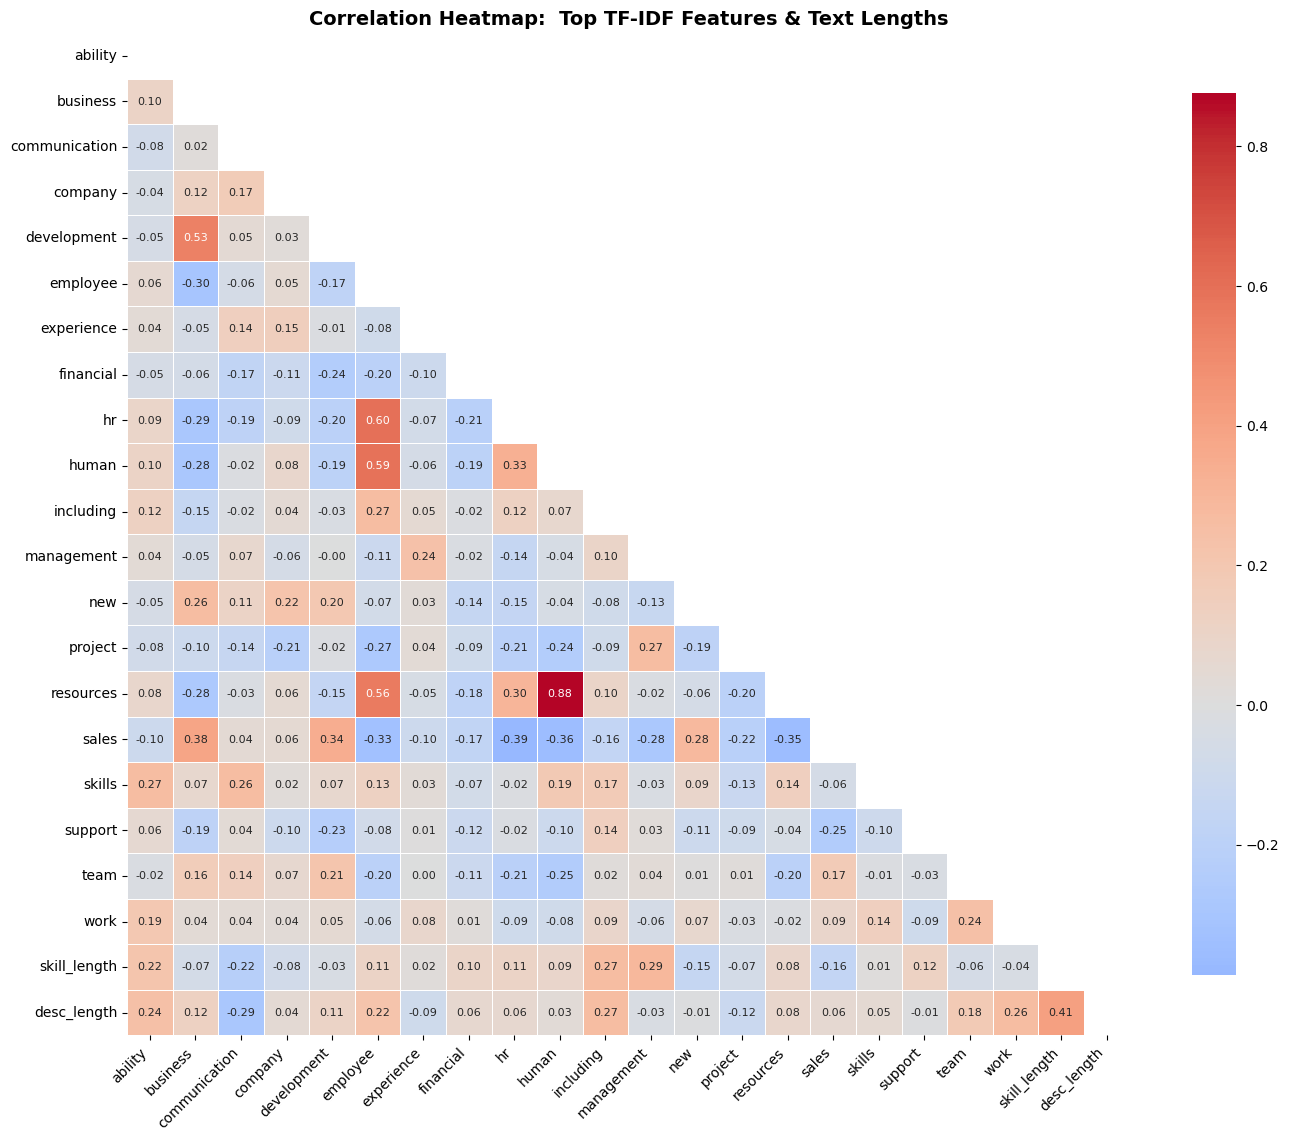

In [74]:
tfidf_viz = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = tfidf_viz.fit_transform(df_filtered['combined_features'])
tfidf_df = pd.DataFrame(tfidf_matrix. toarray(), columns=tfidf_viz.get_feature_names_out())

tfidf_df['skill_length'] = df_filtered['skill_length']. values
tfidf_df['desc_length'] = df_filtered['desc_length'].values

corr_matrix = tfidf_df.corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np. ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                       center=0, square=True, linewidths=0.5, ax=ax,
                       annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Heatmap:  Top TF-IDF Features & Text Lengths', fontsize=14, fontweight='bold')
plt. xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

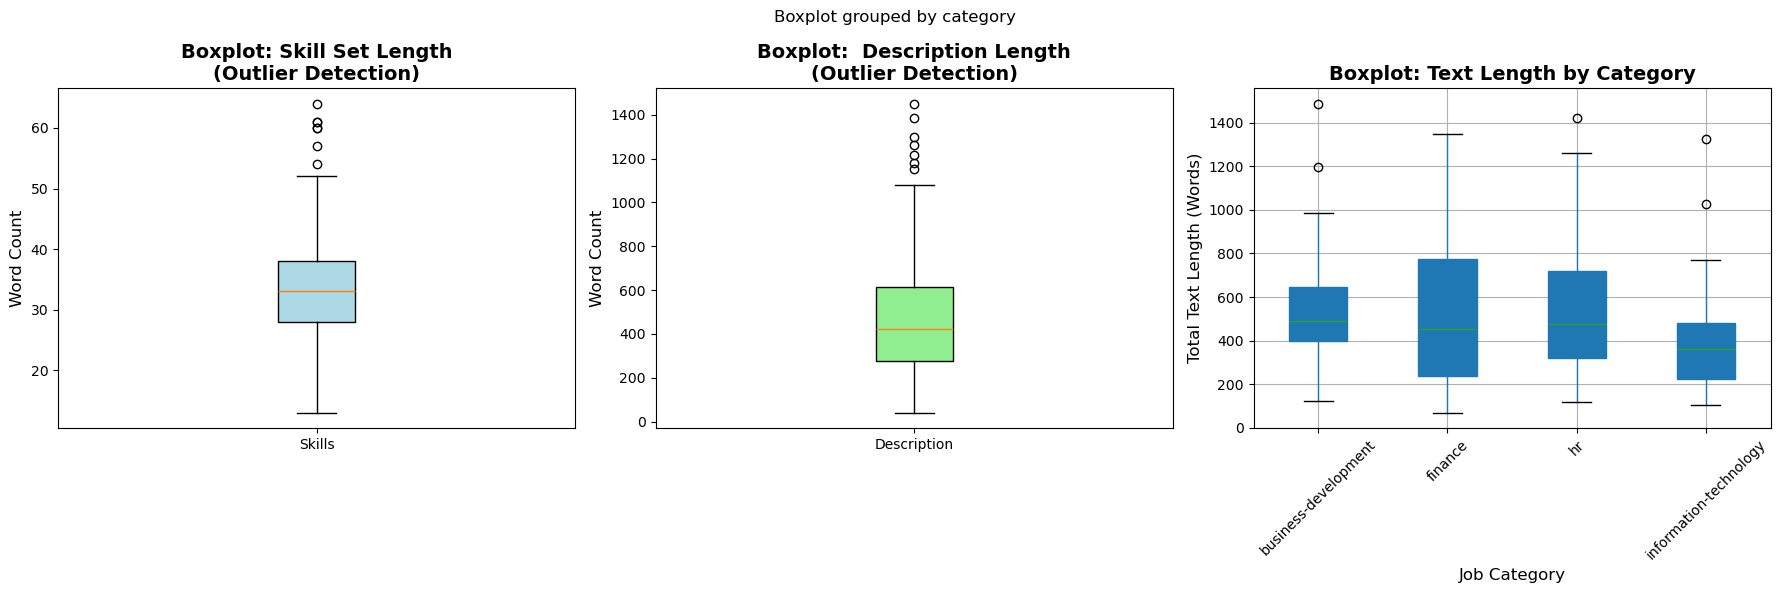


Outlier Analysis (Description Length):
Number of outliers: 7 (2.70%)


In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

bp1 = axes[0].boxplot(df_filtered['skill_length'], patch_artist=True)
bp1['boxes'][0].set_facecolor('lightblue')
axes[0].set_ylabel('Word Count', fontsize=12)
axes[0].set_title('Boxplot: Skill Set Length\n(Outlier Detection)', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Skills'])

bp2 = axes[1]. boxplot(df_filtered['desc_length'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightgreen')
axes[1].set_ylabel('Word Count', fontsize=12)
axes[1].set_title('Boxplot:  Description Length\n(Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['Description'])

top_categories = df_filtered['category'].value_counts().head(8).index
df_top_cat = df_filtered[df_filtered['category'].isin(top_categories)]

bp3 = df_top_cat.boxplot(column='total_text_length', by='category', ax=axes[2], patch_artist=True, rot=45)
axes[2].set_xlabel('Job Category', fontsize=12)
axes[2].set_ylabel('Total Text Length (Words)', fontsize=12)
axes[2].set_title('Boxplot: Text Length by Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Q1 = df_filtered['desc_length'].quantile(0.25)
Q3 = df_filtered['desc_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_filtered[(df_filtered['desc_length'] < Q1 - 1.5*IQR) | (df_filtered['desc_length'] > Q3 + 1.5*IQR)]
print(f"\nOutlier Analysis (Description Length):")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(df_filtered)*100:.2f}%)")

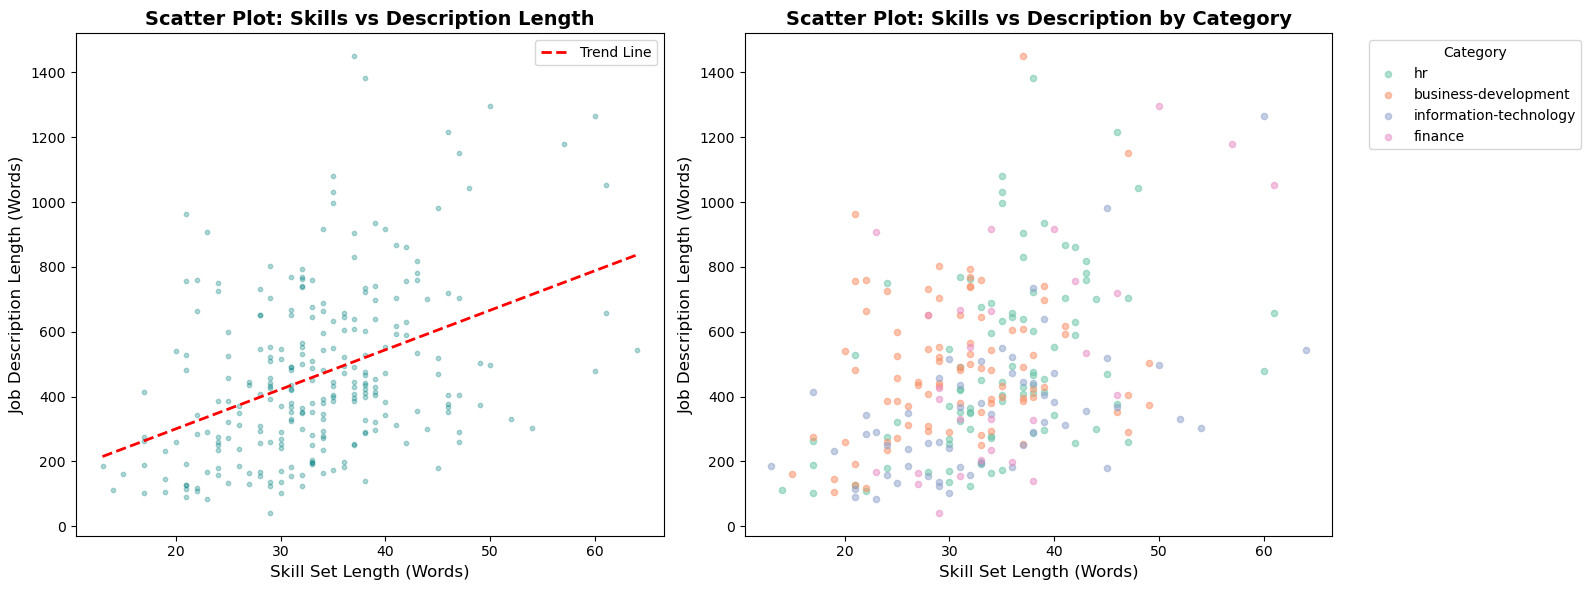

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(df_filtered['skill_length'], df_filtered['desc_length'], alpha=0.3, c='teal', s=10)
axes[0].set_xlabel('Skill Set Length (Words)', fontsize=12)
axes[0].set_ylabel('Job Description Length (Words)', fontsize=12)
axes[0].set_title('Scatter Plot: Skills vs Description Length', fontsize=14, fontweight='bold')

z = np.polyfit(df_filtered['skill_length'], df_filtered['desc_length'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_filtered['skill_length'].min(), df_filtered['skill_length']. max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend Line')
axes[0].legend()

df_sample = df_filtered. sample(n=min(2000, len(df_filtered)), random_state=42)
top_5_cats = df_sample['category'].value_counts().head(5).index
df_sample_top = df_sample[df_sample['category'].isin(top_5_cats)]

colors = sns.color_palette("Set2", 5)
for idx, cat in enumerate(top_5_cats):
    subset = df_sample_top[df_sample_top['category'] == cat]
    axes[1]. scatter(subset['skill_length'], subset['desc_length'], 
                   alpha=0.5, s=20, label=cat, color=colors[idx])

axes[1].set_xlabel('Skill Set Length (Words)', fontsize=12)
axes[1].set_ylabel('Job Description Length (Words)', fontsize=12)
axes[1].set_title('Scatter Plot: Skills vs Description by Category', fontsize=14, fontweight='bold')
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = tfidf.fit_transform(df_final['skills'])
y_title = df_final['job_title']
y_category = df_final['category']

X_train, X_test, y_title_train, y_title_test, y_category_train, y_category_test = train_test_split(X, y_title, y_category, test_size=0.2, random_state=42, stratify=y_title)

cat_nb = MultinomialNB()
cat_nb.fit(X_train, y_category_train)
cat_nb_acc = accuracy_score(y_category_test, cat_nb.predict(X_test))

cat_lr = LogisticRegression(max_iter=1000)
cat_lr.fit(X_train, y_category_train)
cat_lr_acc = accuracy_score(y_category_test, cat_lr.predict(X_test))

cat_rf = RandomForestClassifier(n_estimators=200, random_state=42)
cat_rf.fit(X_train, y_category_train)
cat_rf_acc = accuracy_score(y_category_test, cat_rf.predict(X_test))

print("Model Accuracy for Category")
print(f"Category - Naive Bayes Accuracy:      {cat_nb_acc * 100:.2f}%")
print(f"Category - Logistic Reg Accuracy:     {cat_lr_acc * 100:.2f}%")
print(f"Category - Random Forest Accuracy:    {cat_rf_acc * 100:.2f}%")

title_nb = MultinomialNB()
title_nb.fit(X_train, y_title_train)
title_nb_acc = accuracy_score(y_title_test, title_nb.predict(X_test))

title_lr = LogisticRegression(max_iter=1000)
title_lr.fit(X_train, y_title_train)
title_lr_acc = accuracy_score(y_title_test, title_lr.predict(X_test))

title_rf = RandomForestClassifier(n_estimators=200, random_state=42)
title_rf.fit(X_train, y_title_train)
title_rf_acc = accuracy_score(y_title_test, title_rf.predict(X_test))

print("\nModel Accuracy for Job Titles")
print(f"Job Title - Naive Bayes Accuracy:     {title_nb_acc * 100:.2f}%")
print(f"Job Title - Logistic Reg Accuracy:    {title_lr_acc * 100:.2f}%")
print(f"Job Title - Random Forest Accuracy:   {title_rf_acc * 100:.2f}%")

Model Accuracy for Category
Category - Naive Bayes Accuracy:      90.38%
Category - Logistic Reg Accuracy:     92.31%
Category - Random Forest Accuracy:    94.23%

Model Accuracy for Job Titles
Job Title - Naive Bayes Accuracy:     42.31%
Job Title - Logistic Reg Accuracy:    57.69%
Job Title - Random Forest Accuracy:   65.38%


In [86]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score

def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1-Score": f1}

cat_results = {
    "Naive Bayes": get_metrics(y_category_test, cat_nb.predict(X_test)),
    "Logistic Reg": get_metrics(y_category_test, cat_lr.predict(X_test)),
    "Random Forest": get_metrics(y_category_test, cat_rf.predict(X_test))
}

title_results = {
    "Naive Bayes": get_metrics(y_title_test, title_nb.predict(X_test)),
    "Logistic Reg": get_metrics(y_title_test, title_lr.predict(X_test)),
    "Random Forest": get_metrics(y_title_test, title_rf.predict(X_test))
}

for level, results in [("CATEGORY", cat_results), ("JOB TITLE", title_results)]:
    print(f"\n--- {level} ---")
    print(f"{'Model':<15} | {'Acc':<8} | {'Prec':<8} | {'Rec':<8} | {'F1':<8}")
    for model, m in results.items():
        print(f"{model:<15} | {m['Accuracy']:.3f} | {m['Precision']:.3f} | {m['Recall']:.3f} | {m['F1-Score']:.3f}")


--- CATEGORY ---
Model           | Acc      | Prec     | Rec      | F1      
Naive Bayes     | 0.904 | 0.914 | 0.904 | 0.901
Logistic Reg    | 0.923 | 0.931 | 0.923 | 0.922
Random Forest   | 0.942 | 0.951 | 0.942 | 0.943

--- JOB TITLE ---
Model           | Acc      | Prec     | Rec      | F1      
Naive Bayes     | 0.423 | 0.391 | 0.423 | 0.309
Logistic Reg    | 0.577 | 0.547 | 0.577 | 0.509
Random Forest   | 0.654 | 0.599 | 0.654 | 0.595


In [200]:
def recommend_job(input_skills):
    cleaned_input = clean(input_skills)
    input_vector = tfidf.transform([cleaned_input])
    
    cat_pred = cat_rf.predict(input_vector)[0]
    cat_prob = np.max(cat_rf.predict_proba(input_vector)) * 100
    
    title_pred = title_rf.predict(input_vector)[0]
    title_prob = np.max(title_rf.predict_proba(input_vector)) * 100
    
    return cat_pred, cat_prob, title_pred, title_prob

In [136]:
print("\n" + "="*40)
print("Welcome to the Hierarchical AI Career Assistant!")
print("Enter 'quit' to exit.")
print("="*40)

while True:
    user_input = input("\nPlease enter your skills (separated by commas): ")
    
    if user_input.lower() == 'quit':
        print("Closing application. Good luck!")
        break
    
    cat, cat_score, job, job_score = recommend_job(user_input)
    
    print("-" * 40)
    print(f"AI CAREER PATH ANALYSIS:")
    print(f"1. INDUSTRY:  {cat.upper()} ({cat_score:.1f}%)")
    print(f"2. JOB ROLE:  {job.upper()} ({job_score:.1f}%)")
    print("-" * 40)


Welcome to the Hierarchical AI Career Assistant!
Enter 'quit' to exit.



Please enter your skills (separated by commas):  react, node, expressjs, javascript


----------------------------------------
AI CAREER PATH ANALYSIS:
1. INDUSTRY:  INFORMATION-TECHNOLOGY (57.5%)
2. JOB ROLE:  INFORMATION TECHNOLOGY SUPPORT SPECIALIST (18.5%)
----------------------------------------



Please enter your skills (separated by commas):  sales, marketing, customer, real estate


----------------------------------------
AI CAREER PATH ANALYSIS:
1. INDUSTRY:  BUSINESS-DEVELOPMENT (45.0%)
2. JOB ROLE:  BUSINESS DEVELOPMENT REPRESENTATIVE (27.5%)
----------------------------------------



Please enter your skills (separated by commas):  quit


Closing application. Good luck!
